# Solving and Simulating a DSGE Model in Python

## Using Value-Function Iteration on a Grid
### by [Kerk L. Phillips](https://sites.google.com/site/kerkphillips/home), July 2018

The code in this Jupyter notebook was written using Python 3.6. It also uses the python function, `rouwen.py`. This file can be downloaded at the Python4econ blog - [http://python4econ.blogspot.com/2013/10/rouwenhorst-1995-markov-transition.html](http://python4econ.blogspot.com/2013/10/rouwenhorst-1995-markov-transition.html).  Alternatively, both that file and this notebook can be found in the public GitHub repository [https://github.com/kerkphil/Jupyter_Notebooks](https://github.com/kerkphil/Jupyter_Notebooks).

### This notebook explains how to set up a simple DSGE model and how to solve and simulate it in Python using value-function iteration on a full cartesian grid.

We begin by writing down the behavioral equations for a simple DSGE model.

We use the following definitions:

$k_t$ is the capital stock in period $t$.

$z_t$ is the percent deviation of technology from its long-run value.

$r_t$ is the rental rate on capital.

$w_t$ is the wage rate.

$c_t$ is private consumption.

$i_t$ is investment.

$\varepsilon_t$ is the random innovation to $z_t$

We also have the following parameters:
$\alpha$ is the capital share in GDP.

$\beta$ is the subjective discount factor.

$\gamma$ is the curvature of the utility function.  In our example this is the constant elasticity of intertemporal substitition.  It is also the constant coefficient of relative risk aversion.

$\delta$ is the rate of capital depreciation.

$\rho$ is the autocorrelation of $z_t$.

$\sigma$ is the standard deviation of the $\varepsilon_t$ shocks.

Suppose the household's Bellman equation is given by:
$$ V(k_t, z_t) = \max_{k_{t+1}} \frac{c_t^{1-\gamma}-1}{1-\gamma} + \beta V(k_{t+1}, z_{t+1}) $$

$$ c_t = w_t + (1+r_t-\delta)k_t - k_{t+1} $$

The first-order condition is:
$$ c_t^{-\gamma} = \beta V_k(k_{t+1}, z_{t+1}) $$
The envelope condition is:
$$ \beta V_k(k_t, z_t) = c_t^{-\gamma}(1+r_t-\delta) $$
Combining give the Euler equation:
$$ c_t^{-\gamma} = \beta c_{t+1}^{-\gamma}(1+r_{t+1}-\delta) $$

From the firm's problem we have the following:
$$ y_t = k_t^\alpha e^{(1-\alpha)z_t} $$
$$ r_t = \alpha \frac{y_t}{k_t} $$
$$ w_t = (1-\alpha)y_t $$

Finally, we assume the following law of motion for $ z_t $:
$$ z_t = \rho z_{t-1} + \varepsilon_t; \varepsilon_t \sim iid(0,\sigma^2) $$

## Programming Definitions Functions

First we can define $y_t, r_t, w_t$ and $c_t$ as functions of the state $(k_t, z_t)$ using the budget constraint and the conditions from the firm's problem.  The parameters of the model, $\alpha, \beta, \gamma, \delta, \rho, \& \sigma$, are included in the Python list, `mparams`.

$$ y_t = k_t^\alpha e^{(1-\alpha)z_t} $$
$$ r_t = \alpha \frac{y_t}{k_t} $$
$$ w_t = (1-\alpha)y_t $$
$$ c_t = w_t + (1+r_t-\delta)k_t - k_{t+1} $$
$$ i_t = y_t - c_t $$
$$ u_t = \frac{c_t^{1-\gamma}-1}{1-\gamma} $$

Note we need to consider the case where utility may be undefined.  In these cases we set it to a very large negative number.

In [3]:
def modeldefs(Xm, Xn, Z, *mparams):
    # unpack sets
    k = Xm                            # k(t-1)
    kp = Xn                           # k(t)
    z = Z                             # z(t)
    # find variables
    y = k**alpha*np.exp((1-alpha)*z)  # y(t)
    r = alpha*y/k                     # r(t)
    w = (1-alpha)*y                   # w(t)
    c = w + (1+r-delta)*k - kp        # c(t)
    i = y - c                         # i(t)
    if gamma == 1.0:                  # u(t)
        u = np.log(c)
    else:
        u = (c**(1-gamma)-1)/(1-gamma)
    if np.isnan(u) or np.isinf(u):
        u = -1.0E+99
    return y, r, w, c, i, u

## Writing the Main Program

Now we can write a program that will solve and simulate our model.
First we need to call the Python packages and files we need.

In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rouwen import rouwen

Next we set our parameter values.

In [5]:
alpha = .33
beta = .95
gamma = 2.5
delta = .08
rho = .9
sigma = .02
mparams = (alpha, beta, gamma, delta, rho, sigma)

### Finding the Steady State

With this mode it is straightforward to find an analytical solution for the steady state.

For more complex models this may not be possible and we may need to use numerical techniques.  One way to find a numerical steady state is to use the using the linearization techniques implemented in the `LinApp` package.  This package can be downloaded at this [Github site](https://github.com/kerkphil/DSGE-Utilities). 

To find the steady state use the steady state version of the Euler equation to find $\bar r$
$$ \bar c^{-\gamma} = \beta \bar c^{-\gamma}(1+\bar r_-\delta) $$
$$ \bar r = \frac{1}{\beta} + \delta - 1 $$

Next, use the first-order condition on capital from the firm's problem to find $\bar k$.
$$ \bar r = \alpha \bar k^{\alpha-1} e^{(1-\alpha)0} $$
$$ \bar k = \left( \frac{\alpha}{\bar r} \right)^{\frac{1}{1-\alpha}} $$

In [7]:
# find the steady state
rbar = 1/beta + delta - 1
kbar = (alpha/rbar)**(1/(1-alpha))
print(kbar)

3.8980397970046203


We can get the steady states for all the other variables using our definintions function

In [8]:
zbar = 0.
ybar, rbar, wbar, cbar, ibar, ubar = modeldefs(kbar, kbar, zbar, *mparams)
print('ybar: ', ybar)
print('rbar: ', rbar)
print('wbar: ', wbar)
print('cbar: ', cbar)
print('ibar: ', ibar)
print('ubar: ', ubar)

ybar:  1.5666762820497038
rbar:  0.13263157894736843
wbar:  1.0496731089733013
cbar:  1.2548330982893345
ibar:  0.31184318376036924
ubar:  0.19239214703970364


### Value Function Iteration

The next step is to find value function and policy function, $ k_{t+1} = \Phi(k_t)$, by iteration on a discrete grid of points for $k$ and $z$.

We begin by setting up grids using the steady state values as central points in the grid.  This means we need an odd number of points in the grid.  Having a value of $k=0$, can lead to undefined numbers, so we mke sure that spread of $k$ is such that all values are greater than zero (`keps` > 0 in the code).  For $k$ we set up a grid between $.01 \bar k$ and $1.99 \bar k$, by setting `keps` to .01.  

In [9]:
# set up grid for k
keps = .01
klow = keps*kbar
khigh = (1-keps)*kbar
knpts = 31
kgrid = np.linspace(klow, khigh, num = knpts)

For $z$, our grid is between $-s\sigma$ and $s\sigma$, where we set $s$ as `spread`.

In addition to the grid for $z$, it is also useful to approximate the AR(1) law of motion for $z$ with a Markov process.  The method for doing this was developed by [Tauchen (1986)](http://www.sciencedirect.com/science/article/pii/0165176586901680) and Rouwenhorst (1995).  We use Python code from Ben Tengelson based on MATLAB code from Lu Zhang and Karen Kopecky, which is avialable at [python4econ.blogspot.com](http://python4econ.blogspot.com/2013/10/rouwenhorst-1995-markov-transition.html).

`rouwen.py` is an external python file containing the function, `rouwen(rho, mu, step, num)`.  We must import this by including **`from`** `rouwen` **`import`** `rouwen` at the begining of our program.

This code generates both a grid for $z$ and the Markov transition probabilities of moving from one gridpoint to another from one period to the next.  Denoting the probability of moving from $z_i$ to $z_j$ as $\pi_{ij}$, the matrix is organized with the $i$ corresponding to columns and the $j$ corresponding to rows, so that the columns all sum to one.

We use these probabilities later to take the expected values in the Euler equation over $z_{t+1}$, given a value for $z_t$.

In [10]:
# set up Markov approximation of AR(1) process using Rouwenhorst method
spread = 2.  # number of standard deviations above and below 0
znpts = 11
zstep = 4.*spread*sigma/(znpts-1)
# Markov transition probabilities, current z in cols, next z in rows
Pimat, zgrid = rouwen(rho, 0., zstep, znpts)

Our value function, $V(k_t, z_t)$, is a two-dimensional array with rows corresponding to elements of the $k$ grid, and columns corresponding to the elements of $z$.  We store the value in the cells.

Our policy function, $ k_{t+1} = \Phi(k_t)$, is also a a two-dimensional array with the same rows and columns and we store an the optimal value of $k$ from the $k$ grid in the cells.

We first initialize these arrays.  Note we need a place to hold our updated value function with our iterative procedure.  We call this `VFnew`.

In [11]:
VF = np.zeros((knpts, znpts))
VFnew = np.zeros((knpts, znpts))
PF = np.zeros((knpts, znpts))

We need to set parameter values for the iterative prodcedure.

`ccrit` tells us when the distance between `VF` and `VFnew` is small enough that we have converged to the true value function.  For this example we have set `crit = 1.0E-2` to ensure that the program executes quickly.  A more reasonable value would be something like `crit = 1.0E-10`, but this could take a long time to converge, particularly if the number of grid points is large.

`maxit` is the maximum number of iterations we will allows.  If we have not found the true value fuction by this point, we will terminate the procedure.

`damp` is the weight we put on the new value function relative to the old when moving to the next iteration.  Replacement of the old with the new corresponds to `damp = 1.`

`dist` is the initial distance measure and needs to be larger than `ccrit`.

`iters` is the initial count for the number of iterations peformed.

In [17]:
ccrit = 1.0E-8
maxit = 1000
damp = 1.
dist = 1.0E+99
iters = 0

We next being a while loop where we find a new value for each point in the `VFnew` array.  We compare this to the original `VF` array and terminate if the two are sufficiently close or if we have exceeded the maximum number of iterations.

To find the new values we loop over every possible value of $k_t$ and $z_t$ and calculate the maximimm value of $u(k_t, z_t) + \beta E\{V(k_{t+1}, z_{t+1}) \} $, searching over every possible value of $k_{t+1}$.  We take the expected value over $z_{t+1}$ using the Markov transition probabilities we found earlier and placed in the array, `Pimat`.

For our distance measure we will use either 1) the **mean** absolute deviation of `VF` from `VFnew` or 2) the **maximum** absolute deviation.  The latter is obviously a more restrictive measure of distance.

In [18]:
while (dist > ccrit) and (iters < maxit):
    VFnew.fill(0.0)
    iters = iters + 1
    for i in range (0, knpts):
        for j in range(0, znpts):
            maxval = -1.0E+98
            for m in range(0, knpts):
                # get current period utility
                yout, rat, wag, con, inv, u =  \
                    modeldefs(kgrid[i], kgrid[m], zgrid[j], *mparams)
                # get expected value
                val = 0.
                for n in range (0, znpts):
                    # sum over all possible value of z(t+1) with Markov probs
                    val = val + u + beta*Pimat[n, j]*VF[m, n]
                    # if this exceeds previous maximum do replacements
                if val > maxval:
                    maxval = val
                    VFnew[i, j] = val
                    PF[i, j] = kgrid[m]
    # dist = np.mean(np.abs(VF - VFnew))
    dist = np.amax(np.abs(VF - VFnew))
    print('iteration: ', iters, 'distance: ', dist)
    VF = damp*VFnew + (1-damp)*VF

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


iteration:  1 distance:  0.00925786230067871
iteration:  2 distance:  0.008794907258774742
iteration:  3 distance:  0.008355108938587819
iteration:  4 distance:  0.007937308205661964
iteration:  5 distance:  0.007540404070027762
iteration:  6 distance:  0.007163350751831388
iteration:  7 distance:  0.006805154897712384
iteration:  8 distance:  0.006464872939517363
iteration:  9 distance:  0.006141608588087877
iteration:  10 distance:  0.005834510454789665
iteration:  11 distance:  0.005542769793983382
iteration:  12 distance:  0.005265618360297708
iteration:  13 distance:  0.005002326374437871
iteration:  14 distance:  0.004752200592143652
iteration:  15 distance:  0.004514582470754647
iteration:  16 distance:  0.004288846428401882
iteration:  17 distance:  0.0040743981911433025
iteration:  18 distance:  0.003870673223353549
iteration:  19 distance:  0.003677135237232676
iteration:  20 distance:  0.0034932747774192308
iteration:  21 distance:  0.0033186078767144522
iteration:  22 dista

iteration:  170 distance:  1.5913635493802758e-06
iteration:  171 distance:  1.511795368003277e-06
iteration:  172 distance:  1.4362056006689272e-06
iteration:  173 distance:  1.3643953238329232e-06
iteration:  174 distance:  1.2961755544438347e-06
iteration:  175 distance:  1.2313667809848994e-06
iteration:  176 distance:  1.169798437672398e-06
iteration:  177 distance:  1.1113085136571499e-06
iteration:  178 distance:  1.0557430911717347e-06
iteration:  179 distance:  1.002955940521133e-06
iteration:  180 distance:  9.528081434950764e-07
iteration:  181 distance:  9.051677380966794e-07
iteration:  182 distance:  8.599093490602172e-07
iteration:  183 distance:  8.169138894231764e-07
iteration:  184 distance:  7.760681910440326e-07
iteration:  185 distance:  7.372647772285745e-07
iteration:  186 distance:  7.004015429856736e-07
iteration:  187 distance:  6.653814637047617e-07
iteration:  188 distance:  6.321123890984381e-07
iteration:  189 distance:  6.005067731962299e-07
iteration:  1

We report the number of iterations it took to converge.

We also check to see if the policy function has a steady state at $\bar k$.

In [19]:
print('Converged after', iters, 'iterations')
print('Policy function at (', int((knpts-1)/2), ',', int((znpts-1)/2), ') should be', \
    kgrid[int((knpts-1)/2)], 'and is', PF[int((knpts-1)/2), int((znpts-1)/2)])

Converged after 269 iterations
Policy function at ( 15 , 5 ) should be 1.94901989850231 and is 2.076355865204461


### Fitting the Policy Function with a Polynomial

Our policy function is lumpy in the sense that the value of $k_t$, $z_t$ and $k_{t+1}$ are constrained to be the discrete values found in the grids.  This could be a problem when we simulate if the grids are not fine enough.  Adding more grid points slows down our value-function iteration.  One solution is to use a relativel coarse grid that will allow a quick solution for our value and policy functions, but to then fit the policy function with a continuous mutivariate polynomial in $k_t$ and $z_t$.  We do this below with a cubic polynomial.

We first set up two-dimensional arrays for k and z, which give the value of these variables over the same space as the value function.  This is done using the meshgrid function in numpy.

Next, we flatten the policy function from two dimensions to one and use this as the dependent variable in our regression.  For our independent variables we take appropriate powers of our k and z meshes, flatten them, and add them to the list of regressors.

We then perform an OLS regression to generate fitted coefficients.

In [20]:
# fit a polynomial
# create meshgrid
zmesh, kmesh = np.meshgrid(zgrid, kgrid)

Y = PF.flatten()

X = np.ones(knpts*znpts)

temp = kmesh.flatten()
X = np.vstack((X,temp))

temp = kmesh**2
temp = temp.flatten()
X = np.vstack((X,temp))

temp = kmesh**3
temp = temp.flatten()
X = np.vstack((X,temp))

temp = zmesh.flatten()
X = np.vstack((X,temp))

temp = zmesh**2
temp = temp.flatten()
X = np.vstack((X,temp))

temp = zmesh**3
temp = temp.flatten()
X = np.vstack((X,temp))

temp = kmesh*zmesh
temp = temp.flatten()
X = np.vstack((X,temp))

temp = kmesh**2*zmesh
temp = temp.flatten()
X = np.vstack((X,temp))

temp = kmesh*zmesh**2
temp = temp.flatten()
X = np.vstack((X,temp))

XtX = np.dot(X,np.transpose(X))
XtY = np.dot(X,Y)
coeffs = np.dot(np.linalg.inv(XtX),XtY)

With these coefficient estimates we can now produce a polynomial fitted version of the policy function.  We loop over all values of k and z in the grids and generate fitted values using the estimated coefficients.  We then compare these to the grid-based policy function to get a goodness of fit measure.

In [22]:
PFpoly = np.zeros((knpts, znpts))
for i in range(0, knpts):
    for j in range(0, znpts):
        PFpoly[i,j] = np.dot(np.stack((1, kgrid[i], kgrid[i]**2, kgrid[i]**3, \
        zgrid[j], zgrid[j]**2, zgrid[j]**3, \
        kgrid[i]*zgrid[j], kgrid[i]**2*zgrid[j], kgrid[i]*zgrid[j]**2)),coeffs)
        
# calcuate R-squared
Rsq = 1 - np.sum((PF-PFpoly)**2)/np.sum(PF**2)
print('R-squared', Rsq)

R-squared 0.999797232146072


We can check how well our polynomial does at the steady state by putting in steady state values for k and z, and seeing how close it comes to generating kbar.

In [23]:
# check polynomial
check = np.dot(np.stack((1, kbar, kbar**2, kbar**3, \
        zbar, zbar**2, zbar**3, kbar*zbar, \
        kbar**2*zbar, kbar*zbar**2)),coeffs)
print('Value of Phi(kbar) from polynomial: ', check)
print('kbar: ', kbar)
print('Percent difference: ', check/kbar - 1.)
diff = check - kbar
print('Absolute diffence: ', diff)

Value of Phi(kbar) from polynomial:  3.912925164864295
kbar:  3.8980397970046203
Percent difference:  0.003818680320070822
Absolute diffence:  0.014885367859674759


Notice that the steady state value generated by the policy function is not the same as the steady state we found earlier.  This is because one we found first is the 'certainty equivalence' steady state.  That is the one to which the model would converge if there were never any stochastic shocks and the agents in the model knew this.  In reality our model has stochastic shocks and our agents are risk averse.  This leads to a higher level of savings because of a precautionary motive that does not exist in the certainty version of the model.

Lastly, we print surface plots of the grid-based value function, the grid-based policy function, and the polynomial policy function.

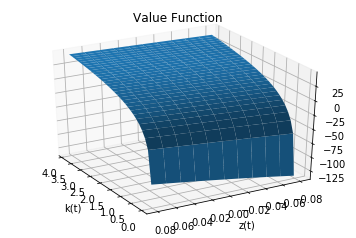

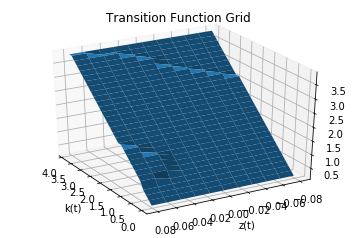

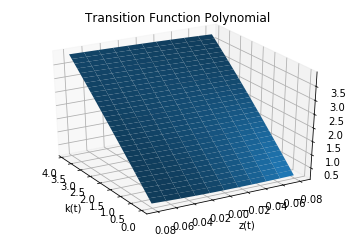

In [24]:
# plot value function and transition function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(kmesh, zmesh, VF)
ax.view_init(30, 150)
plt.title('Value Function')
plt.xlabel('k(t)')
plt.ylabel('z(t)')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(kmesh, zmesh, PF)
ax.view_init(30, 150)
plt.title('Transition Function Grid')
plt.xlabel('k(t)')
plt.ylabel('z(t)')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(kmesh, zmesh, PFpoly)
ax.view_init(30, 150)
plt.title('Transition Function Polynomial')
plt.xlabel('k(t)')
plt.ylabel('z(t)')
plt.show()

### Simulating the Model

Finally we simulate our model using the fitted polynomial


In [26]:
# perform simulation
T = 1000  # number of periods to simulate
kstart = kbar # starting value for simulation
# initialize variable histories
epshist = np.random.randn(T)*sigma
khist= np.zeros(T+1)
zhist = np.zeros(T+1)
yhist = np.zeros(T)
rhist= np.zeros(T)
whist = np.zeros(T)
chist = np.zeros(T)
ihist = np.zeros(T)
uhist = np.zeros(T)
khist[0] = kstart
for t in range(0, T):
    # perform simulation with polynomial fit
    khist[t+1] = np.dot(np.stack((1, khist[t], khist[t]**2, khist[t]**3, \
        zhist[t], zhist[t]**2, zhist[t]**3, khist[t]*zhist[t], \
        khist[t]**2*zhist[t], khist[t]*zhist[t]**2)),coeffs)
    zhist[t+1] = zhist[t]*rho + epshist[t]   
    yhist[t], rhist[t], whist[t], chist[t], ihist[t], uhist[t] = \
        modeldefs(khist[t], khist[t+1], zhist[t], *mparams)   
# remove final k & z
khist = khist[0:T]
zhist = zhist[0:T]

Lastly we can plot our simulated data.

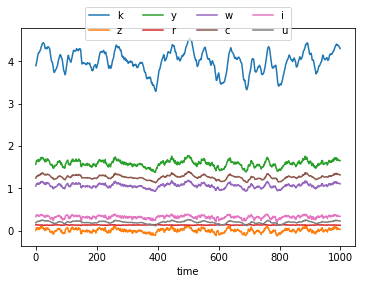

In [27]:
# plot data
t = range(0, T)
plt.plot(t, khist, label='k')
plt.plot(t, zhist, label='z')
plt.plot(t, yhist, label='y')
plt.plot(t, rhist, label='r')
plt.plot(t, whist, label='w')
plt.plot(t, chist, label='c')
plt.plot(t, ihist, label='i')
plt.plot(t, uhist, label='u')
plt.xlabel('time')
plt.legend(loc=9, ncol=4, bbox_to_anchor=(0., 1.02, 1., .102))
plt.show()